## Import the required packages

In [0]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)


Mounted at /gdrive


In [0]:
import os; import sys; sys.path.insert(0,'../')
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm

In [0]:
!pip install socceraction

     |████████████████████████████████| 245kB 4.2MB/s 
  Created wheel for socceraction: filename=socceraction-0.1.1-cp36-none-any.whl size=25652 sha256=fc2b4e65303028254c6b9eeb81680ff8547491dbc6dc5e9cc6cf645f2d11ca4a
  Stored in directory: /root/.cache/pip/wheels/74/ac/2e/806e2f9940e240846e7182093719294722304c07a8dab31753
Successfully built socceraction


In [0]:
import socceraction.spadl as spadl
import socceraction.spadl.statsbomb as statsbomb

## Read the data

In [0]:
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = statsbomb.StatsBombLoader(root=free_open_data_remote,getter="remote")

In [0]:
competitions = SBL.competitions()
set(competitions.competition_name)

{"FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 "Women's World Cup"}

In [0]:
# Fifa world cup
selected_competitions = competitions[competitions.competition_name=="FIFA World Cup"]

selected_competitions

competition_id  ...             match_available
2              43  ...  2019-12-16T23:09:16.168756

[1 rows x 8 columns]

## Preprocessing the data to store new tables

In [0]:
matches = list(
    SBL.matches(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
matches = pd.concat(matches, sort=True).reset_index(drop=True)
matches[["home_team_name","away_team_name","match_date","home_score","away_score"]].head()

home_team_name away_team_name  match_date  home_score  away_score
0      Australia           Peru  2018-06-26           0           2
1        Nigeria        Iceland  2018-06-22           2           0
2         Serbia         Brazil  2018-06-27           0           2
3        Croatia        Denmark  2018-07-01           1           1
4           Iran       Portugal  2018-06-25           1           1

In [0]:
matches_verbose = tqdm.tqdm(list(matches.itertuples()),desc="Loading match data")
teams,players,player_games = [],[],[]
actions = {}
for match in matches_verbose:
    # load data
    teams.append(SBL.teams(match.match_id))
    players.append(SBL.players(match.match_id))
    events = SBL.events(match.match_id)
    
    # convert data
    player_games.append(statsbomb.extract_player_games(events))
    actions[match.match_id] = statsbomb.convert_to_actions(events,match.home_team_id)

games = matches.rename(columns={"match_id":"game_id"})
teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).drop_duplicates("player_id").reset_index(drop=True)
player_games = pd.concat(player_games).reset_index(drop=True)

Loading match data: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]


In [0]:
datafolder = "/gdrive/My Drive/datasets/football"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created ")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players
    spadlstore["player_games"] = player_games
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]
        
    spadlstore["actiontypes"] = spadl.actiontypes_df()
    spadlstore["results"] = spadl.results_df()
    spadlstore["bodyparts"] = spadl.bodyparts_df()

In [0]:
!pip install --upgrade tables

     |████████████████████████████████| 4.3MB 2.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [0]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = spadlstore["games"].merge(spadlstore["competitions"])
    game_id = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Belgium")].game_id.values[0]
    actions = spadlstore[f"actions/game_{game_id}"]
    actions = (
        actions.merge(spadlstore["actiontypes"],how="left")
        .merge(spadlstore["results"],how="left")
        .merge(spadlstore["bodyparts"],how="left")
        .merge(spadlstore["players"],how="left")
        .merge(spadlstore["teams"],how="left")
    )

# use nickname if available else use full name
actions["player"] = actions[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
actions[:5]

game_id  period_id  time_seconds  ... extra  team_name          player
0     8657          1           0.0  ...    {}    Belgium   Romelu Lukaku
1     8657          1           1.0  ...    {}    Belgium     Axel Witsel
2     8657          1           2.0  ...    {}    Belgium     Axel Witsel
3     8657          1           3.0  ...    {}    Belgium  Jan Vertonghen
4     8657          1           4.0  ...    {}    Belgium  Jan Vertonghen

[5 rows x 25 columns]

In [0]:
!pip install matplotsoccer

  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-cp36-none-any.whl size=5984 sha256=3b6b791aa54d879b5aab30e0828199d25ccd86b8f57d85323969c227a33f202b
  Stored in directory: /root/.cache/pip/wheels/69/af/8d/ee61635d6f863657abe8cd0c22622c408a4b980d5af1974f1f
Successfully built matplotsoccer


## Plot buildup to a shot

2018-07-14 Belgium 2-0 England 82'


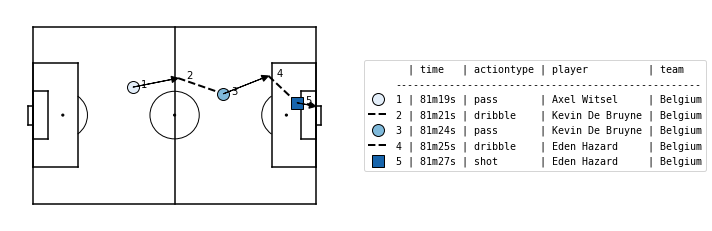

In [0]:
import matplotsoccer

shot = 2201
a = actions[shot-4:shot+1].copy()

g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
minute = int((a.period_id.values[0]-1)*45 +a.time_seconds.values[0] // 60)
game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "player", "team_name"]]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team=a.team_name,
    result=a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    zoom=False,
    figsize=6
)

## Predict the xG and XG conceded

In [0]:
import socceraction.classification.features as fs
import socceraction.classification.labels as lab

In [0]:
datafolder = "/gdrive/My Drive/datasets/football/"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder,"features.h5")
labels_h5 = os.path.join(datafolder,"labels.h5")

In [0]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

nb of games: 64


In [0]:
xfns = [fs.actiontype,
       fs.actiontype_onehot,
       fs.bodypart,
       fs.bodypart_onehot,
       fs.result,
       fs.result_onehot,
       fs.goalscore,
       fs.startlocation,
       fs.endlocation,
       fs.movement,
       fs.space_delta,
       fs.startpolar,
       fs.endpolar,
       fs.team,
       fs.time,
       fs.time_delta
      ]

for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {features_h5}"):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(results,how="left")
        .merge(bodyparts,how="left")
        .reset_index(drop=True)
    )
    gamestates = fs.gamestates(actions,3)
    gamestates = fs.play_left_to_right(gamestates,game.home_team_id)
    
    X = pd.concat([fn(gamestates) for fn in xfns],axis=1)
    X.to_hdf(features_h5,f"game_{game.game_id}")


Generating and storing features in /gdrive/My Drive/datasets/football/features.h5: 100%|██████████| 64/64 [00:18<00:00,  3.51it/s]


In [0]:
yfns = [lab.scores,lab.concedes,lab.goal_from_shot]

for game in tqdm.tqdm(list(games.itertuples()),desc=f"Computing and storing labels in {labels_h5}"):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(results,how="left")
        .merge(bodyparts,how="left")
        .reset_index(drop=True)
    )
    
    Y = pd.concat([fn(actions) for fn in yfns],axis=1)
    Y.to_hdf(labels_h5,f"game_{game.game_id}")

Computing and storing labels in /gdrive/My Drive/datasets/football/labels.h5: 100%|██████████| 64/64 [00:08<00:00,  7.12it/s]


In [0]:
predictions_h5 = os.path.join(datafolder,"predictions.h5")

In [0]:
xfns = [fs.actiontype,
       fs.actiontype_onehot,
       #fs.bodypart,
       fs.bodypart_onehot,
       fs.result,
       fs.result_onehot,
       fs.goalscore,
       fs.startlocation,
       fs.endlocation,
       fs.movement,
       fs.space_delta,
       fs.startpolar,
       fs.endpolar,
       fs.team,
       #fs.time,
       fs.time_delta,
       #fs.actiontype_result_onehot
      ]
nb_prev_actions = 1

# generate the columns of the selected features
Xcols = fs.feature_column_names(xfns,nb_prev_actions)
X = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting features"):
    Xi = pd.read_hdf(features_h5,f"game_{game_id}")
    X.append(Xi[Xcols])
X = pd.concat(X)

# 2. Select label Y
Ycols = ["scores","concedes"]
Y = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting label"):
    Yi = pd.read_hdf(labels_h5,f"game_{game_id}")
    Y.append(Yi[Ycols])
Y = pd.concat(Y)
print("X:", list(X.columns))
print("Y:", list(Y.columns))


selecting label: 100%|██████████| 64/64 [00:31<00:00,  2.00it/s]

X: ['type_id_a0', 'type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'bodypart_foot_a0', 'bodypart_head_a0', 'bodypart_other_a0', 'result_id_a0', 'result_fail_a0', 'result_success_a0', 'result_offside_a0', 'result_owngoal_a0', 'result_yellow_card_a0', 'result_red_card_a0', 'goalscore_team', 'goalscore_opponent', 'goalscore_diff', 'start_x_a0', 'start_y_a0', 'end_x_a0', 'end_y_a0', 'dx_a0', 'dy_a0', 'movement_a0', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'end_dist_to_goal_a0', 'end_angle_to_goal_a0']
Y: ['scores', 'concedes']


In [0]:
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier()
    model.fit(X,Y[col])
    models[col] = model

In [0]:
from sklearn.metrics import brier_score_loss, roc_auc_score

Y_hat = pd.DataFrame()
for col in Y.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(X)]
    print(f"Y: {col}")
    print(f"  Brier score: %.4f" % brier_score_loss(Y[col],Y_hat[col]))
    print(f"  ROC AUC: %.4f" % roc_auc_score(Y[col],Y_hat[col]))

Y: scores
  Brier score: 0.0092
  ROC AUC: 0.8479
Y: concedes
  Brier score: 0.0024
  ROC AUC: 0.8740


In [0]:
A = []
for game_id in tqdm.tqdm(games.game_id,"loading game ids"):
    Ai = pd.read_hdf(spadl_h5,f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A,Y_hat],axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions,desc="saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5,f"game_{int(k)}")

saving predictions per game: 100%|██████████| 64/64 [00:01<00:00, 44.57it/s]


*----------------------------------8

## VAEP cacluation

In [0]:
import socceraction.vaep as vaep

In [0]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(results,how="left")
        .merge(bodyparts,how="left")
        .merge(players,how="left")
        .merge(teams,how="left")
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 64/64 [00:05<00:00, 12.08it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'player_nickname', 'jersey_number',
       'country_id', 'country_name', 'extra', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

2018-06-28 England 0-1 Belgium 9' dribble Michy Batshuayi Tunga


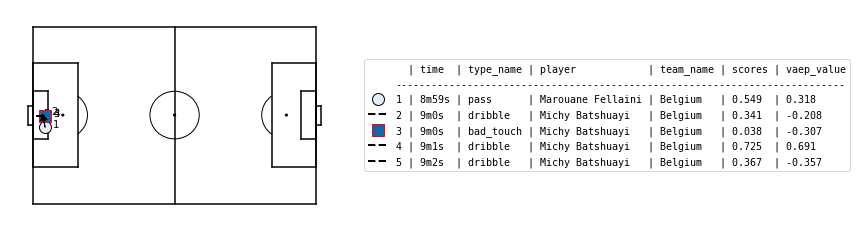

2018-06-28 England 0-1 Belgium 8' pass Marouane Fellaini-Bakkioui


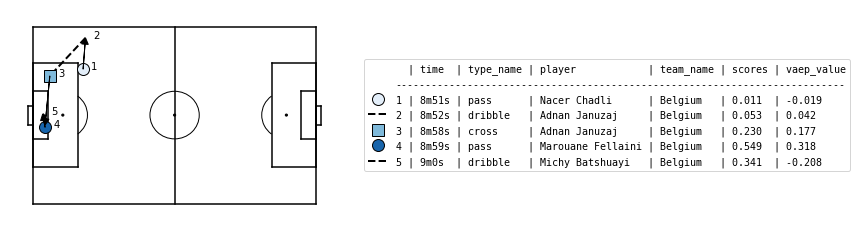

2018-06-23 Belgium 5-2 Tunisia 80' cross Kevin De Bruyne


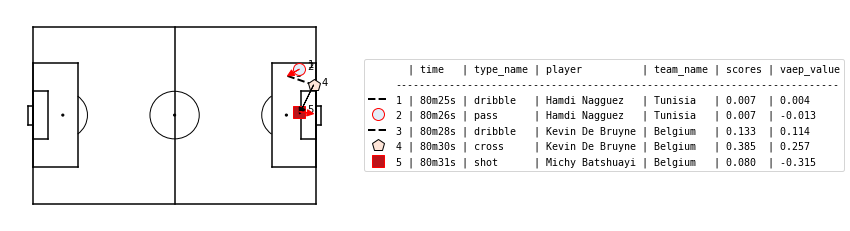

2018-07-02 Belgium 3-2 Japan 77' cross Nacer Chadli


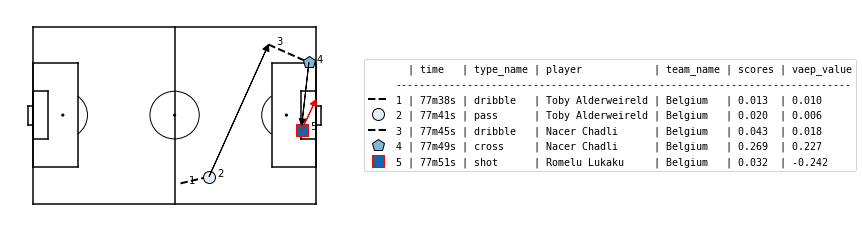

2018-07-02 Belgium 3-2 Japan 24' cross Dries Mertens


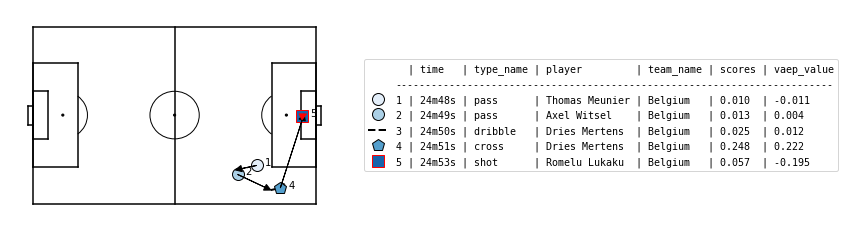

2018-07-02 Belgium 3-2 Japan 73' cross Eden Hazard


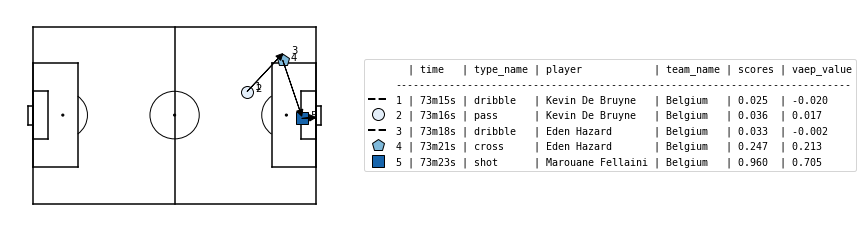

2018-06-23 Belgium 5-2 Tunisia 89' cross Youri Tielemans


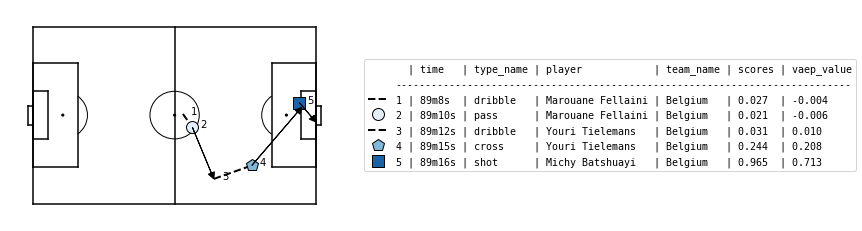

2018-07-10 France 1-0 Belgium 46' pass Axel Witsel


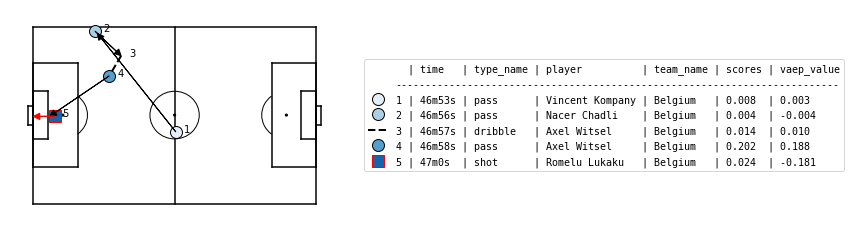

2018-07-10 France 1-0 Belgium 21' corner_crossed Nacer Chadli


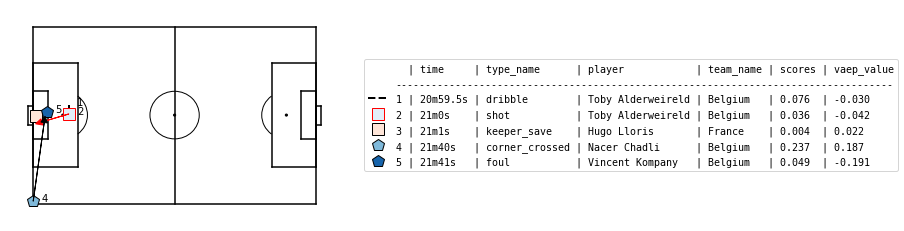

2018-06-23 Belgium 5-2 Tunisia 47' pass Thomas Meunier


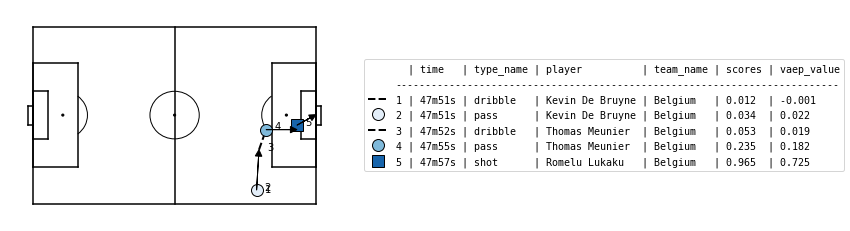

2018-06-28 England 0-1 Belgium 8' cross Adnan Januzaj


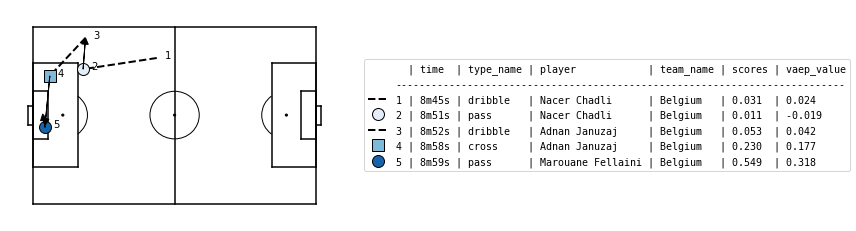

2018-07-02 Belgium 3-2 Japan 85' pass Nacer Chadli


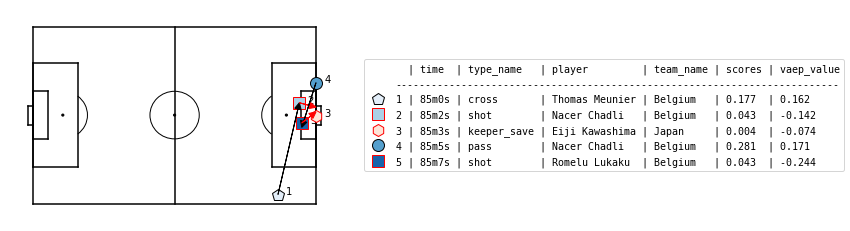

2018-06-23 Belgium 5-2 Tunisia 91' dribble Michy Batshuayi Tunga


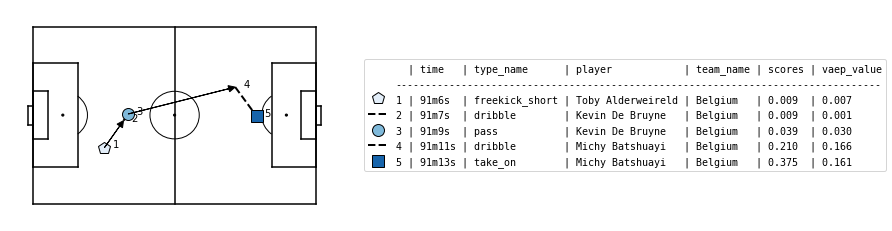

2018-06-18 Belgium 3-0 Panama 68' pass Kevin De Bruyne


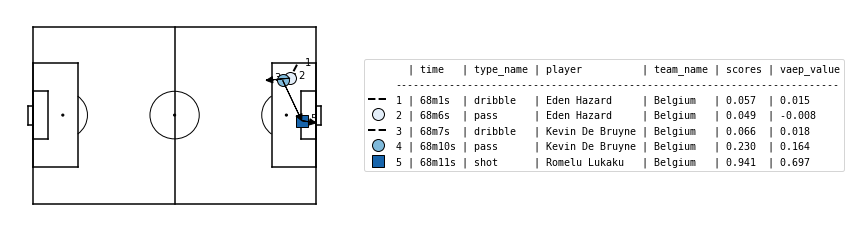

2018-07-02 Belgium 3-2 Japan 85' cross Thomas Meunier


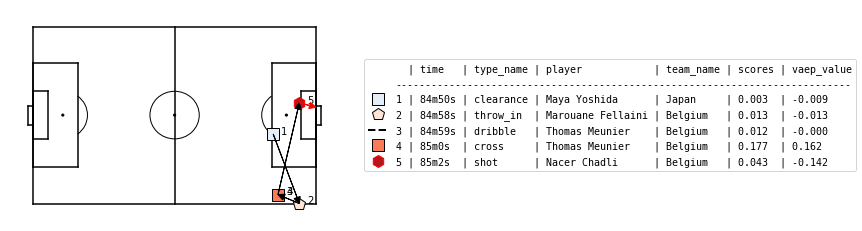

2018-06-23 Belgium 5-2 Tunisia 91' take_on Michy Batshuayi Tunga


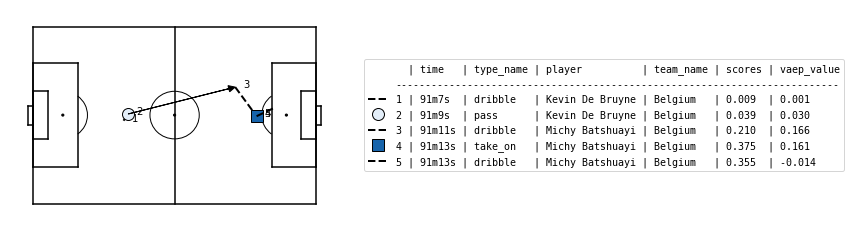

2018-07-02 Belgium 3-2 Japan 93' pass Thomas Meunier


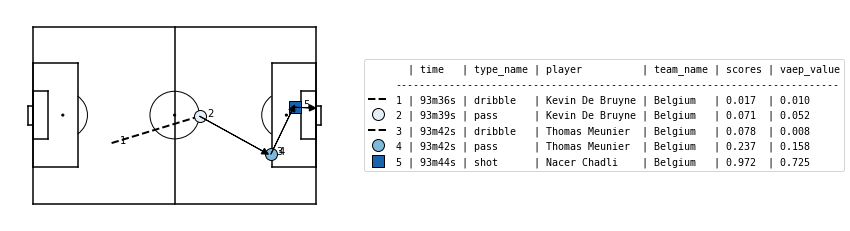

2018-07-14 Belgium 2-0 England 3' cross Nacer Chadli


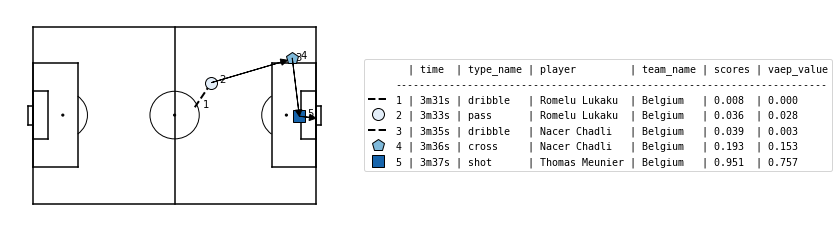

2018-07-02 Belgium 3-2 Japan 61' cross Thomas Meunier


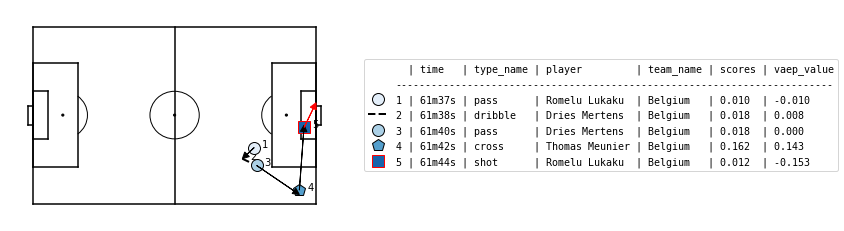

2018-07-02 Belgium 3-2 Japan 27' cross Kevin De Bruyne


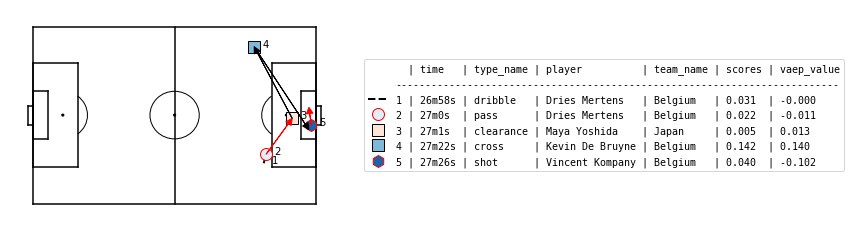

2018-07-06 Brazil 1-2 Belgium 61' dribble Vincent Kompany


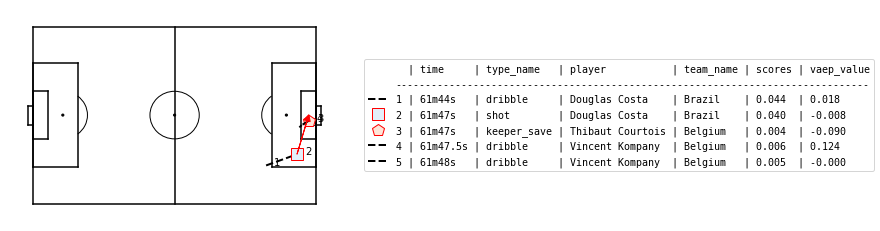

2018-06-23 Belgium 5-2 Tunisia 50' dribble Eden Hazard


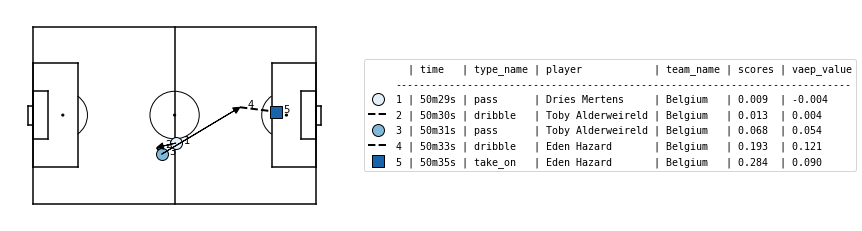

2018-06-23 Belgium 5-2 Tunisia 80' dribble Kevin De Bruyne


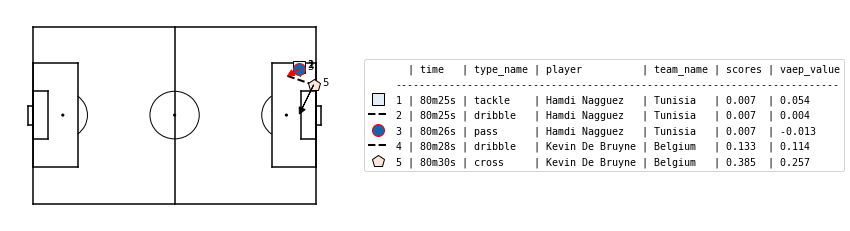

2018-07-02 Belgium 3-2 Japan 87' dribble Romelu Lukaku Menama


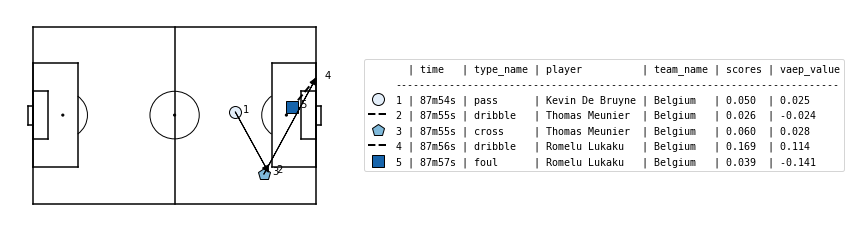

2018-07-14 Belgium 2-0 England 81' dribble Eden Hazard


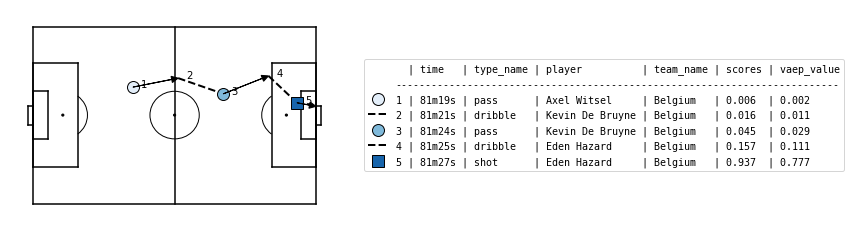

2018-07-02 Belgium 3-2 Japan 79' dribble Vincent Kompany


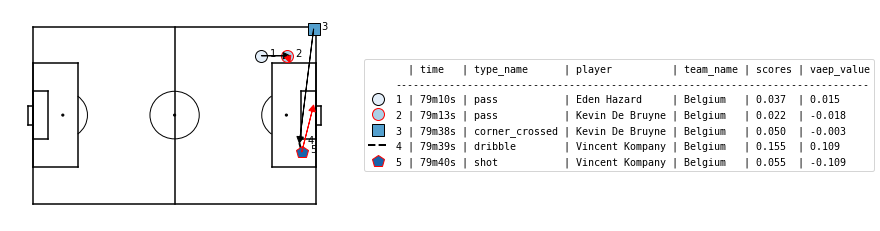

2018-06-18 Belgium 3-0 Panama 35' cross Thomas Meunier


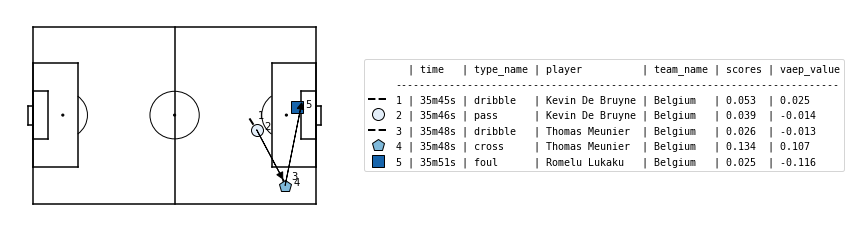

2018-06-23 Belgium 5-2 Tunisia 12' cross Romelu Lukaku Menama


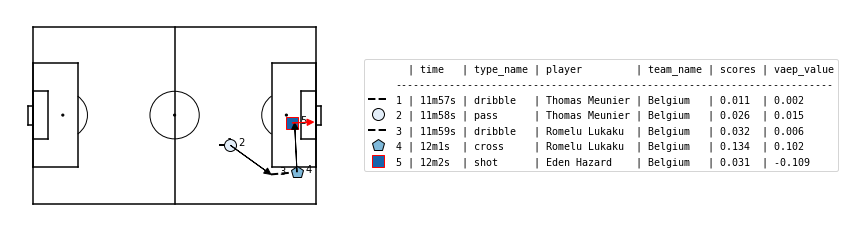

2018-06-23 Belgium 5-2 Tunisia 46' cross Kevin De Bruyne


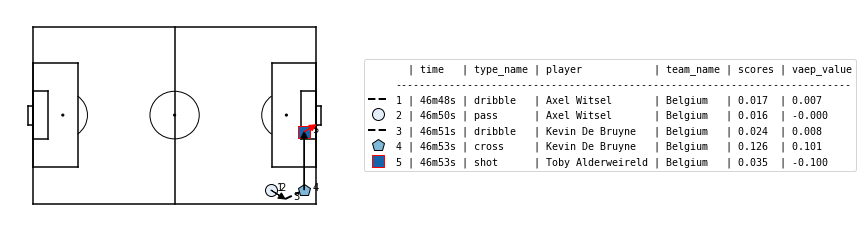

2018-06-18 Belgium 3-0 Panama 0' cross Yannick Ferreira Carrasco


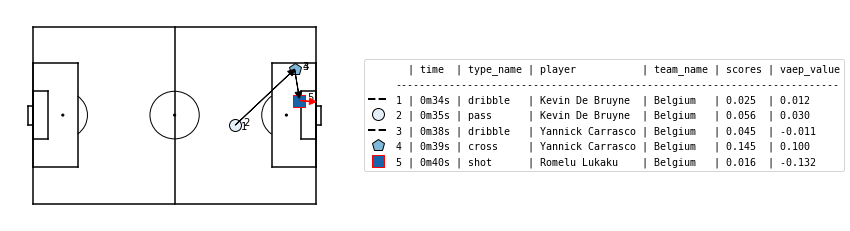

2018-06-18 Belgium 3-0 Panama 91' pass Moussa Sidi Yaya Dembélé


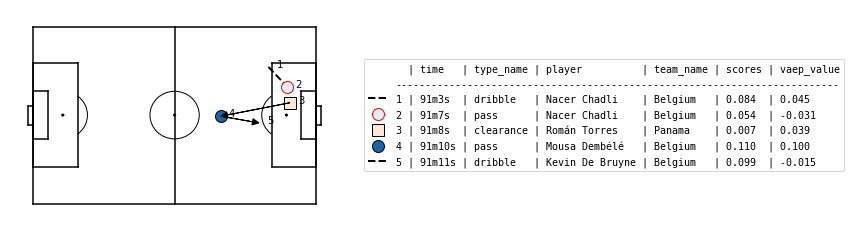

2018-06-23 Belgium 5-2 Tunisia 80' dribble Michy Batshuayi Tunga


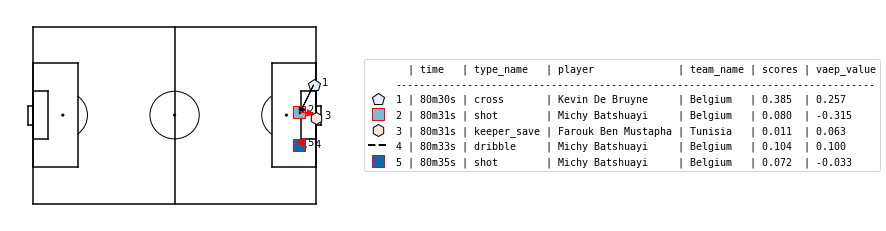

2018-06-23 Belgium 5-2 Tunisia 79' dribble Michy Batshuayi Tunga


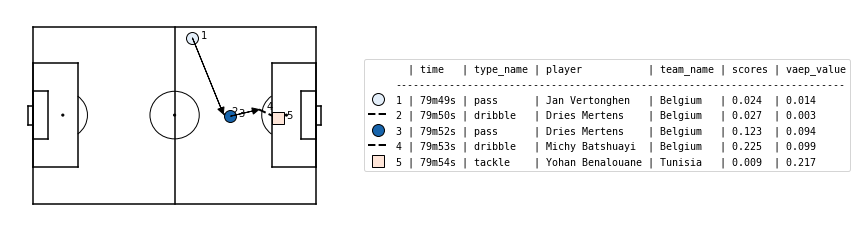

2018-07-10 France 1-0 Belgium 60' dribble Kevin De Bruyne


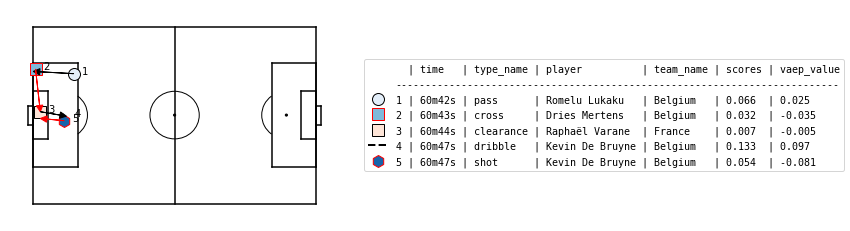

2018-07-14 Belgium 2-0 England 11' dribble Kevin De Bruyne


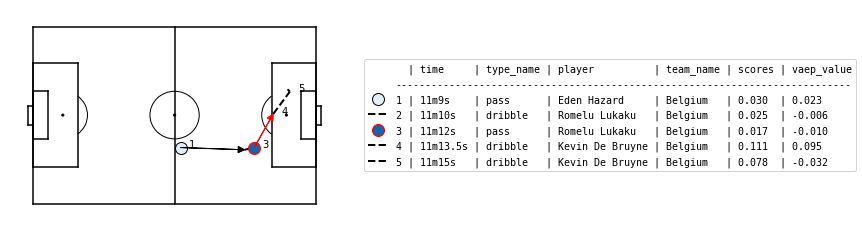

2018-07-02 Belgium 3-2 Japan 67' cross Thomas Meunier


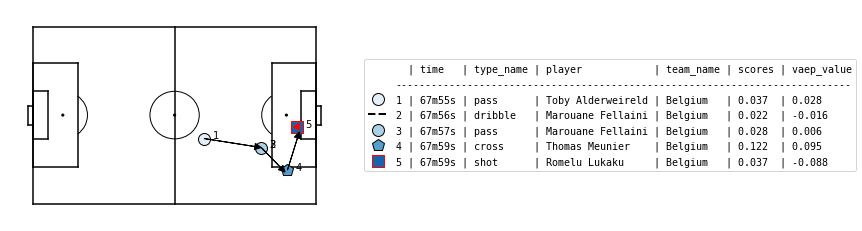

2018-06-23 Belgium 5-2 Tunisia 79' pass Dries Mertens


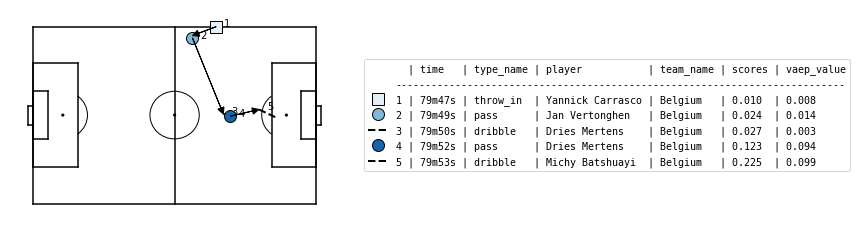

2018-07-02 Belgium 3-2 Japan 48' dribble Eden Hazard


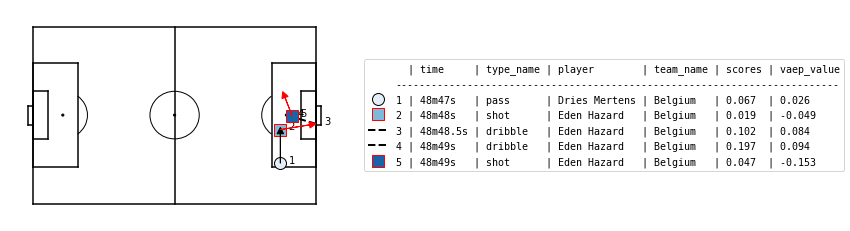

2018-06-23 Belgium 5-2 Tunisia 75' pass Dries Mertens


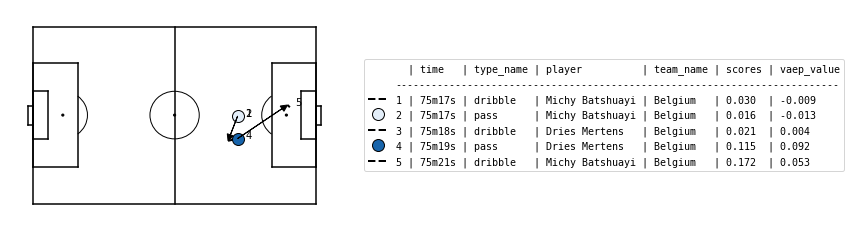

2018-06-23 Belgium 5-2 Tunisia 50' take_on Eden Hazard


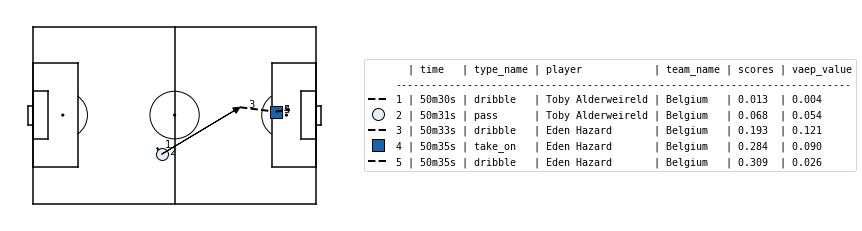

2018-07-02 Belgium 3-2 Japan 40' freekick_crossed Kevin De Bruyne


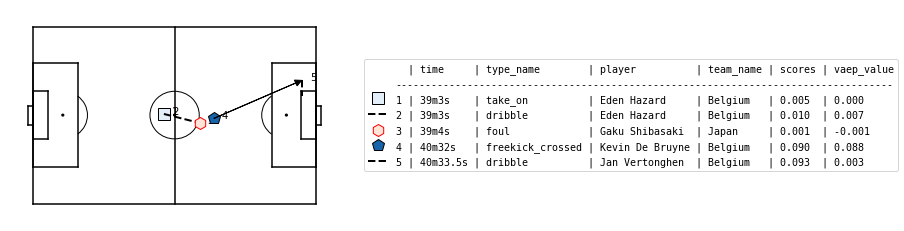

2018-06-28 England 0-1 Belgium 35' corner_crossed Thorgan Hazard


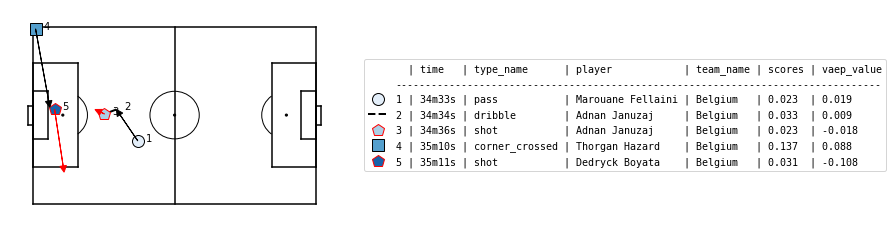

2018-07-02 Belgium 3-2 Japan 48' dribble Eden Hazard


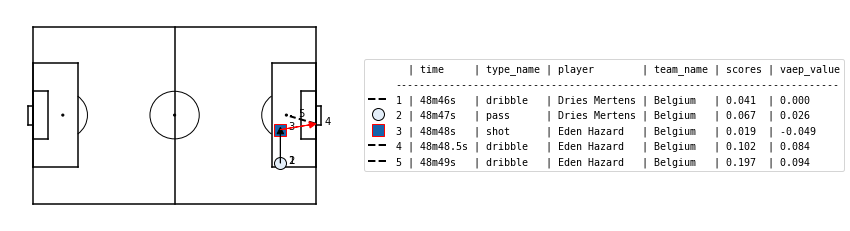

2018-07-14 Belgium 2-0 England 17' tackle Vincent Kompany


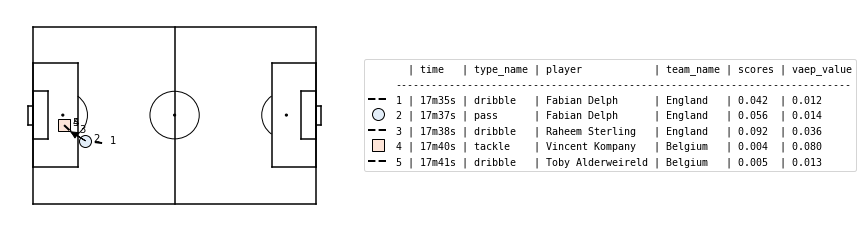

2018-06-28 England 0-1 Belgium 36' freekick_crossed Youri Tielemans


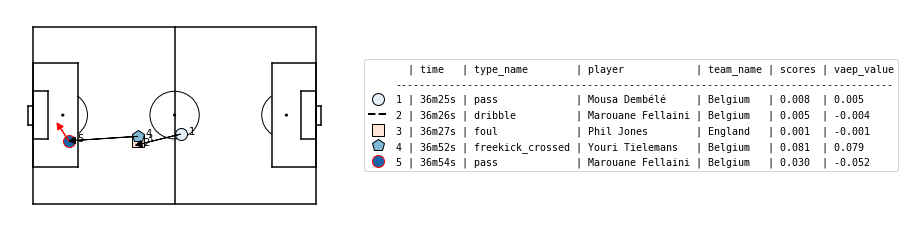

2018-07-02 Belgium 3-2 Japan 8' pass Dries Mertens


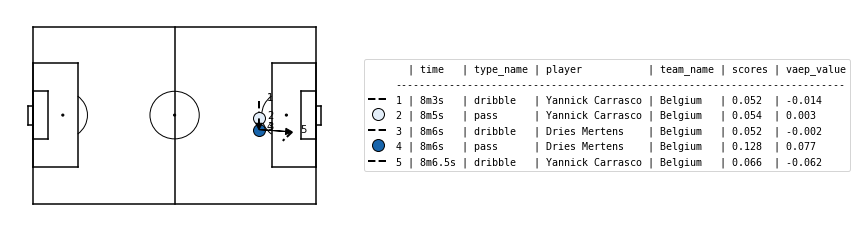

2018-06-28 England 0-1 Belgium 90' cross Michy Batshuayi Tunga


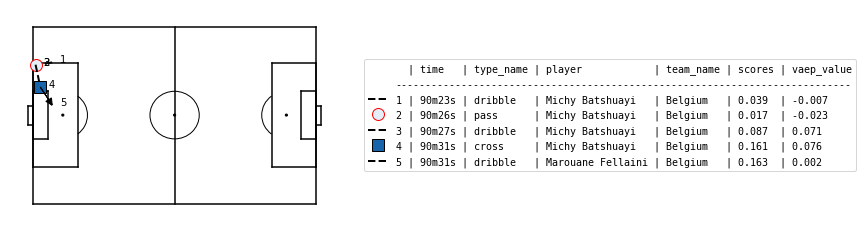

2018-07-06 Brazil 1-2 Belgium 41' corner_crossed Nacer Chadli


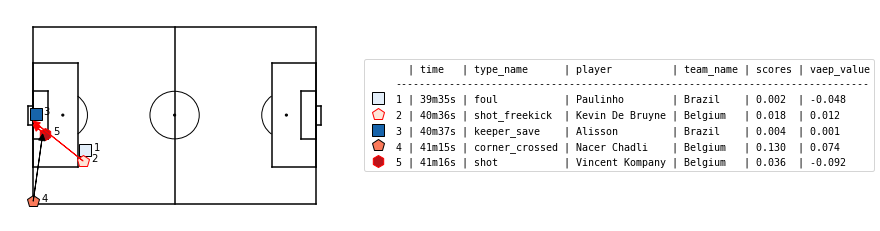

2018-06-23 Belgium 5-2 Tunisia 18' cross Thomas Meunier


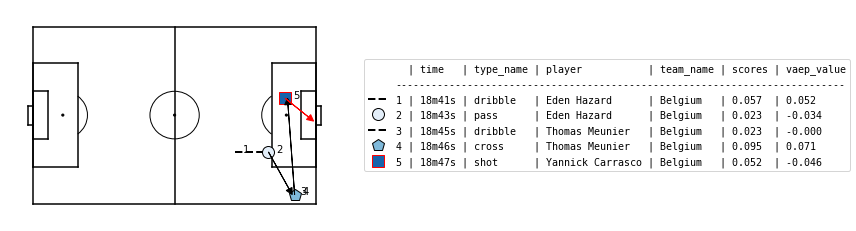

2018-06-28 England 0-1 Belgium 90' dribble Michy Batshuayi Tunga


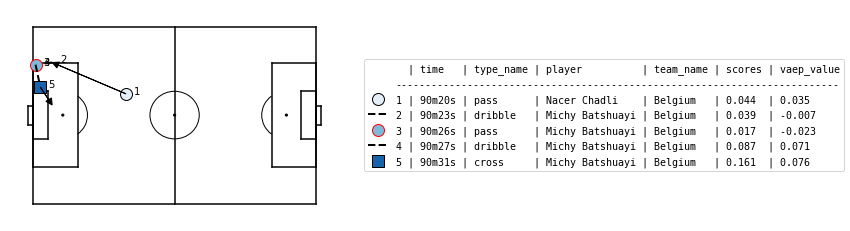

In [0]:
sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,50):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player"] = a[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time","type_name","player","team_name","scores","vaep_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)

## Find the mvp in WC(top 10)

In [0]:
A["player"] = A[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)

A["count"] = 1

players = (
    A[["player_id","team_name","player","vaep_value","count"]]
    .groupby(["player_id","team_name","player"])
    .sum()
    .reset_index()
)
players = players.sort_values("vaep_value",ascending=False)
players[:10]

player_id team_name           player  vaep_value  count
6         3009    France    Kylian Mbappé    3.788137    495
50        3308   England  Kieran Trippier    3.564976    690
122       4320    Brazil           Neymar    3.235207    749
17        3089   Belgium  Kevin De Bruyne    3.213972    716
92        3621   Belgium      Eden Hazard    3.092135    691
152       5186    Russia  Denis Cheryshev    3.022713    214
599      20004    France       Paul Pogba    3.011299    676
36        3244   England      John Stones    2.856670    937
352       5574   Germany       Toni Kroos    2.769772    647
121       4319   Uruguay   Edinson Cavani    2.769654    226

## Now lets see for per game/per 90mins

In [0]:
pg = pd.read_hdf(spadl_h5,"player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id","minutes_played"]].groupby("player_id").sum().reset_index()
stats = players.merge(mp)
stats = stats[stats.minutes_played > 180]
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

player_id    team_name           player  ...  count  minutes_played  vaep_rating
5        5186       Russia  Denis Cheryshev  ...    214             312     0.871937
8        5574      Germany       Toni Kroos  ...    647             289     0.862559
21       5473      Nigeria       Ahmed Musa  ...    162             220     0.735835
26       5674      Senegal     Moussa Wagué  ...    168             208     0.735327
9        4319      Uruguay   Edinson Cavani  ...    226             355     0.702166
32       3237    Argentina    Sergio Agüero  ...    137             193     0.679984
11       6196     Colombia       Yerry Mina  ...    325             315     0.667950
0        3009       France    Kylian Mbappé  ...    495             550     0.619877
2        4320       Brazil           Neymar  ...    749             478     0.609139
22       3083  South Korea    Son Heung-Min  ...    230             288     0.560148

[10 rows x 7 columns]

### Create train and test frames

In [0]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
traingames = games[:len(games)//2]
testgames = games[len(games)//2:]
print(len(traingames),len(testgames))

32 32


In [0]:
def get_shots(games):
    shots = []
    with pd.HDFStore(spadl_h5) as spadlstore,\
         pd.HDFStore(features_h5) as featurestore:
        actiontypes = spadlstore["actiontypes"]
        for game_id in tqdm.tqdm(games.game_id,desc="selecting features"):
            ai = (spadlstore[f"actions/game_{game_id}"]
                  .merge(actiontypes,how="left")
                 )
            shot_idx = ai.type_name.str.contains("shot")
            Xi = featurestore[f"game_{game_id}"]
            shots.append(Xi[shot_idx])
    return pd.concat(shots)

train_shots = get_shots(traingames)
test_shots = get_shots(testgames)

selecting features: 100%|██████████| 32/32 [00:01<00:00, 27.25it/s]


In [0]:
# Decide which features to use to compute the expected goals value of the shots

xfns = [fs.actiontype_onehot,
       fs.bodypart_onehot,
       fs.goalscore,
       fs.startlocation,
       fs.movement,
       fs.space_delta,
       fs.startpolar,
       fs.team,
       fs.time,
       fs.time_delta,
       ]
nb_prev_actions = 2

f = fs.feature_column_names(xfns,nb_prev_actions)
f.remove("dx_a0")
f.remove("dy_a0")
f

['type_pass_a0',
 'type_cross_a0',
 'type_throw_in_a0',
 'type_freekick_crossed_a0',
 'type_freekick_short_a0',
 'type_corner_crossed_a0',
 'type_corner_short_a0',
 'type_take_on_a0',
 'type_foul_a0',
 'type_tackle_a0',
 'type_interception_a0',
 'type_shot_a0',
 'type_shot_penalty_a0',
 'type_shot_freekick_a0',
 'type_keeper_save_a0',
 'type_keeper_claim_a0',
 'type_keeper_punch_a0',
 'type_keeper_pick_up_a0',
 'type_clearance_a0',
 'type_bad_touch_a0',
 'type_non_action_a0',
 'type_dribble_a0',
 'type_goalkick_a0',
 'type_pass_a1',
 'type_cross_a1',
 'type_throw_in_a1',
 'type_freekick_crossed_a1',
 'type_freekick_short_a1',
 'type_corner_crossed_a1',
 'type_corner_short_a1',
 'type_take_on_a1',
 'type_foul_a1',
 'type_tackle_a1',
 'type_interception_a1',
 'type_shot_a1',
 'type_shot_penalty_a1',
 'type_shot_freekick_a1',
 'type_keeper_save_a1',
 'type_keeper_claim_a1',
 'type_keeper_punch_a1',
 'type_keeper_pick_up_a1',
 'type_clearance_a1',
 'type_bad_touch_a1',
 'type_non_action_a1

In [0]:
# Create features-matrix X and label-vector y.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from xgboost import XGBClassifier

def Xy(f,shots):
    return shots[f],shots.result_success_a0

##Logistic Regression model

In [0]:
# Logistic regression
X,y = Xy(f,train_shots)
model = LogisticRegression().fit(X,y)

X,y = Xy(f,test_shots)
pred = [p[1] for p in model.predict_proba(X)]

print("ROC AUC: %.3f" % roc_auc_score(y,pred))
print("Brier score: %.3f" % brier_score_loss(y,pred))
print("Log loss: %.3f" % log_loss(y,pred))

ROC AUC: 0.814
Brier score: 0.078
Log loss: 0.342


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
# XGBoost
X,y = Xy(f,train_shots)
model = XGBClassifier().fit(X,y)

X,y = Xy(f,test_shots)
pred = [p[1] for p in model.predict_proba(X)]

print("ROC AUC: %.3f" % roc_auc_score(y,pred))
print("Brier score: %.3f" % brier_score_loss(y,pred))
print("Log loss: %.3f" % log_loss(y,pred))

ROC AUC: 0.863
Brier score: 0.072
Log loss: 0.249


## xT - Expected Threat model

In [0]:
## Read in all actions of games
A = []

for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(results,how="left")
        .merge(bodyparts,how="left")
        #.sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    [actions] = fs.play_left_to_right([actions],game.home_team_id)
        
    A.append(actions) 
    
A = pd.concat(A)

100%|██████████| 64/64 [00:02<00:00, 23.02it/s]


In [0]:
## Train model
import socceraction.xthreat as xthreat
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

# iterations:  45


In [0]:
# xT should only be used to value actions that move the ball 
# and also keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(A)
mov_actions["xT_value"] = xTModel.predict(mov_actions)
mov_actions[["type_name","start_x","start_y","end_x","end_y","xT_value"]][:15]

type_name    start_x    start_y      end_x      end_y  xT_value
0       pass  52.058824  33.569620  37.941176  34.430380 -0.002159
1    dribble  37.941176  34.430380  39.705882  33.569620  0.000266
2       pass  39.705882  33.569620  33.529412  45.620253 -0.000854
3    dribble  33.529412  45.620253  34.411765  44.759494  0.000120
4       pass  34.411765  44.759494  35.294118   4.303797 -0.001261
5    dribble  35.294118   4.303797  37.058824   3.443038  0.000123
6       pass  37.058824   3.443038  32.647059  33.569620  0.000953
7    dribble  32.647059  33.569620  32.647059  36.151899  0.000032
8       pass  32.647059  36.151899  46.764706  50.784810  0.001590
9    dribble  46.764706  50.784810  48.529412  52.506329  0.000261
10      pass  48.529412  52.506329  54.705882  66.278481 -0.000327
11   dribble  54.705882  66.278481  52.058824  66.278481 -0.000464
12      pass  52.058824  66.278481  37.941176  57.670886 -0.001132
13   dribble  37.941176  57.670886  38.823529  49.924051  0.000588
14      pass  38.823529  49.924051  41.470588  23.240506  0.000394

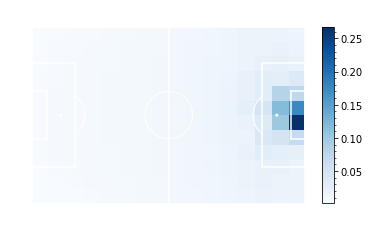

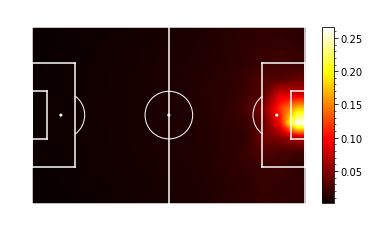

In [0]:
import matplotsoccer as mps
import numpy as np


# Inspect the learned heatmap
mps.heatmap(xTModel.xT,linecolor="white",cbar="True")

# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0,105,1050)
y = np.linspace(0,68,680)
mps.heatmap(interp(x,y),cmap="hot",linecolor="white",cbar="True")

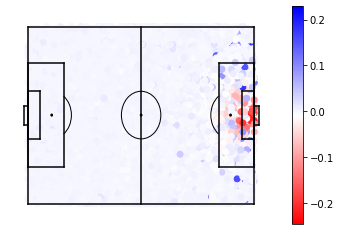

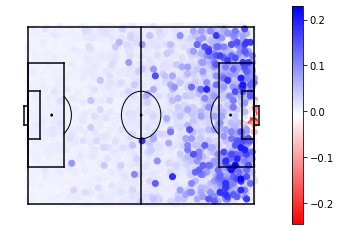

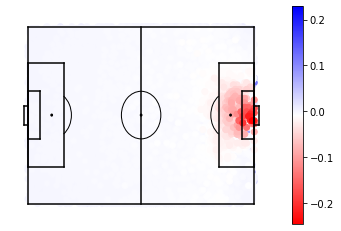

In [0]:
import matplotlib.pyplot as plt

## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.scatter(a.start_x, a.start_y,c=a.xT_value,cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value",ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y,c=a.xT_value,cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value",ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y,c=a.xT_value,cmap="bwr_r")
plt.colorbar()
plt.show()
